<a href="https://colab.research.google.com/github/ihawryluk/importations/blob/main/Double_spike_analyse_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SET THE WRITE PROPERTY BEFORE YOU RUN THIS SCRIPT

Decide if you want to overwrite the saved plots or not

In [40]:
SAVE = False
savepath = '/content/drive/My Drive/Colab Notebooks/importations/Figures/Double_spike/'

# Install and import packages

In [2]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 5.1 MB/s eta 0:00:00


In [3]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.8 MB/s eta 0:00:00


In [4]:
!pip install properscoring

In [5]:
!pip install CRPS

In [6]:
import numpyro
import jax
numpyro.set_host_device_count(4)  # 4 cores
from jax import vmap
import jax.numpy as jnp
import jax.random as random

from numpyro.infer import Predictive
import numpyro.distributions as dist
import arviz as az
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan

from scipy.stats import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import arviz as az
import dill
from properscoring import crps_ensemble as crps
# import CRPS.CRPS as crps

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error as mse

Mounted at /content/drive


# Load all simulated data and results

In [7]:
ls /content/drive/MyDrive/Colab\ Notebooks/importations/Data/Double_spike/

mcmc_10a.pkl  mcmc_1a.pkl  mcmc_4a.pkl  mcmc_7a.pkl  sim_double_spike_mu.csv
mcmc_10.pkl   mcmc_1.pkl   mcmc_4.pkl   mcmc_7.pkl   sim_double_spike_Rt.csv
mcmc_11a.pkl  mcmc_2a.pkl  mcmc_5a.pkl  mcmc_8a.pkl  sim_double_spike_y.csv
mcmc_11.pkl   mcmc_2.pkl   mcmc_5.pkl   mcmc_8.pkl
mcmc_12a.pkl  mcmc_3a.pkl  mcmc_6a.pkl  mcmc_9a.pkl
mcmc_12.pkl   mcmc_3.pkl   mcmc_6.pkl   mcmc_9.pkl


In [8]:
path = '/content/drive/My Drive/Colab Notebooks/importations/Data/Double_spike/'

In [9]:
mu_df = pd.read_csv(path + 'sim_double_spike_mu.csv')
y_df = pd.read_csv(path + 'sim_double_spike_y.csv')
Rt_df = pd.read_csv(path + 'sim_double_spike_Rt.csv')


In [10]:
# high variance model results
with open(path + 'mcmc_1.pkl', 'rb') as f:
    mcmc1 = dill.load(f)
with open(path + 'mcmc_2.pkl', 'rb') as f:
    mcmc2 = dill.load(f)
with open(path + 'mcmc_3.pkl', 'rb') as f:
    mcmc3 = dill.load(f)
with open(path + 'mcmc_4.pkl', 'rb') as f:
    mcmc4 = dill.load(f)
with open(path + 'mcmc_5.pkl', 'rb') as f:
    mcmc5 = dill.load(f)
with open(path + 'mcmc_6.pkl', 'rb') as f:
    mcmc6 = dill.load(f)
with open(path + 'mcmc_7.pkl', 'rb') as f:
    mcmc7 = dill.load(f)
with open(path + 'mcmc_8.pkl', 'rb') as f:
    mcmc8 = dill.load(f)
with open(path + 'mcmc_9.pkl', 'rb') as f:
    mcmc9 = dill.load(f)
with open(path + 'mcmc_10.pkl', 'rb') as f:
    mcmc10 = dill.load(f)
with open(path + 'mcmc_11.pkl', 'rb') as f:
    mcmc11 = dill.load(f)
with open(path + 'mcmc_12.pkl', 'rb') as f:
    mcmc12 = dill.load(f)

In [11]:
# low variance model results
with open(path + 'mcmc_1a.pkl', 'rb') as f:
    mcmc1a = dill.load(f)
with open(path + 'mcmc_2a.pkl', 'rb') as f:
    mcmc2a = dill.load(f)
with open(path + 'mcmc_3a.pkl', 'rb') as f:
    mcmc3a = dill.load(f)
with open(path + 'mcmc_4a.pkl', 'rb') as f:
    mcmc4a = dill.load(f)
with open(path + 'mcmc_5a.pkl', 'rb') as f:
    mcmc5a = dill.load(f)
with open(path + 'mcmc_6a.pkl', 'rb') as f:
    mcmc6a = dill.load(f)
with open(path + 'mcmc_7a.pkl', 'rb') as f:
    mcmc7a = dill.load(f)
with open(path + 'mcmc_8a.pkl', 'rb') as f:
    mcmc8a = dill.load(f)
with open(path + 'mcmc_9a.pkl', 'rb') as f:
    mcmc9a = dill.load(f)
with open(path + 'mcmc_10a.pkl', 'rb') as f:
    mcmc10a = dill.load(f)
with open(path + 'mcmc_11a.pkl', 'rb') as f:
    mcmc11a = dill.load(f)
with open(path + 'mcmc_12a.pkl', 'rb') as f:
    mcmc12a = dill.load(f)

In [12]:
scenarios_names = ['placeholder',
                   r'second spike when $R_t$ decreasing, equal spikes',
                   r'second spike when $R_t$ decreasing, first spike higher',
                   r'second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 300$',
                   r'second spike when $R_t$ increasing but inc ~ 0, equal spikes',
                   r'second spike when $R_t$ increasing but inc ~ 0, first spike higher',
                   r'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 300$',
                  r'second spike when $R_t$ increasing, equal spikes',
                   r'second spike when $R_t$ increasing, first spike higher',
                   r'second spike when $R_t$ increasing, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ increasing, second spike higher, $\mu_2 = 300$'
                   ]

# Posteriors


In [32]:
import matplotlib.pyplot as plt

def plot_posterior_two_samples(mcmc_high, mcmc_low, R, mu, inc, title):

    samples1 = mcmc_high.get_samples()
    samples2 = mcmc_low.get_samples()

    n = samples1['R'].shape[1]
    plt.figure(figsize=(20,5))

    x = np.arange(n)
    plt.subplot(1,4,1)
    plt.fill_between(x, np.percentile(samples1['R'], 5, axis=0), np.percentile(samples1['R'], 95, axis=0), alpha=0.3, label='CrI $\hat{R}_t$', color='tab:blue')
    plt.plot(x, np.percentile(samples1['R'], 50, axis=0), label=r'median $\hat{R}_t$', color='tab:blue')
    plt.plot(R, color='red', alpha=1.0, label=r'true $R_t$')
    plt.legend(fontsize='x-large')
    plt.ylim(-0.5,14)
    plt.xlabel('day', fontsize='xx-large')
    plt.ylabel(r'$R_t$', fontsize='xx-large')
    plt.title(r'$R_t$ for high $R_t$ var', fontsize='xx-large')
    plt.xticks(fontsize='x-large')  # Adjust x-axis tick label size
    plt.yticks(fontsize='x-large')  # Adjust y-axis tick label size

    plt.subplot(1,4,2)
    plt.fill_between(x, np.percentile(samples1['mu'], 5, axis=0), np.percentile(samples1['mu'], 95, axis=0), alpha=0.3, label='CrI $\hat{\mu}$', color='tab:blue')
    plt.plot(x, np.percentile(samples1['mu'], 50, axis=0), label=r'median $\hat{\mu}$', color='tab:blue')
    plt.plot(mu, color='red', alpha=1.0, label=r'true $\mu$')
    plt.plot(inc, color='orange', alpha=1.0, label=r'total $y(t)$')
    plt.legend(fontsize='x-large')
    plt.xlabel('day', fontsize='xx-large')
    plt.ylabel('# new cases', fontsize='xx-large')
    plt.title(r'$y(t)$ for high $R_t$ var', fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')

    plt.subplot(1,4,3)
    plt.fill_between(x, np.percentile(samples2['R'], 5, axis=0), np.percentile(samples2['R'], 95, axis=0), alpha=0.3, label='CrI $\hat{R}_t$', color='tab:blue')
    plt.plot(x, np.percentile(samples2['R'], 50, axis=0), label=r'median $\hat{R}_t$', color='tab:blue')
    plt.plot(R, color='red', alpha=1.0, label=r'true $R_t$')
    plt.legend(fontsize='x-large')
    plt.ylim(-0.5,14)
    plt.xlabel('day', fontsize='xx-large')
    plt.ylabel(r'$R_t$', fontsize='xx-large')
    plt.title(r'$R_t$ for low $R_t$ var', fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')

    plt.subplot(1,4,4)
    plt.fill_between(x, np.percentile(samples2['mu'], 5, axis=0), np.percentile(samples2['mu'], 95, axis=0), alpha=0.3, label='CrI $\hat{\mu}$', color='tab:blue')
    plt.plot(x, np.percentile(samples2['mu'], 50, axis=0), label=r'median $\hat{\mu}$', color='tab:blue')
    plt.plot(mu, color='red', alpha=1.0, label=r'true $\mu$')
    plt.plot(inc, color='orange', alpha=1.0, label=r'total $y(t)$')
    plt.legend(fontsize='x-large')
    plt.xlabel('day', fontsize='xx-large')
    plt.ylabel('# new cases', fontsize='xx-large')
    plt.title(r'$y(t)$ for low $R_t$ var', fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')

    # plt.suptitle(title, fontsize='xx-large')
    plt.tight_layout()


    if SAVE:
      namefile = 'posteriors_' + title.replace(' ', '_')
      plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

    else:
      plt.show()



## Plot posteriors

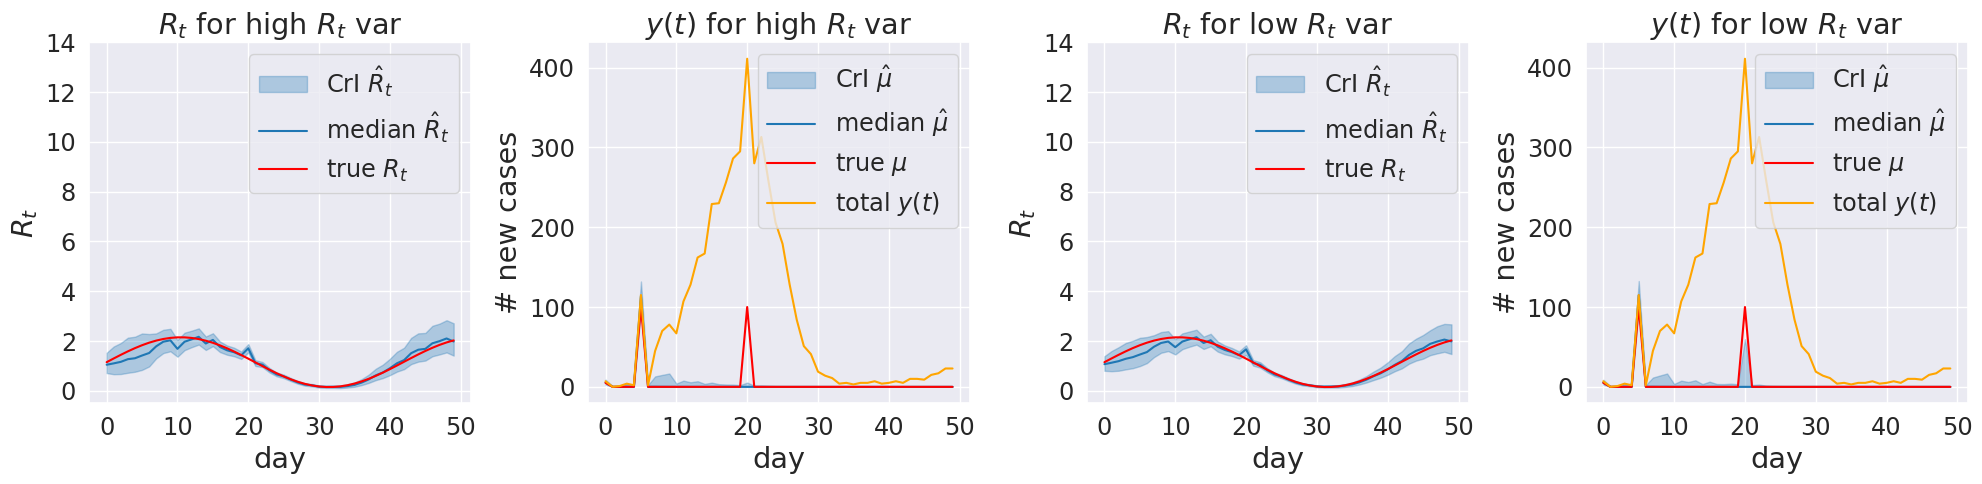

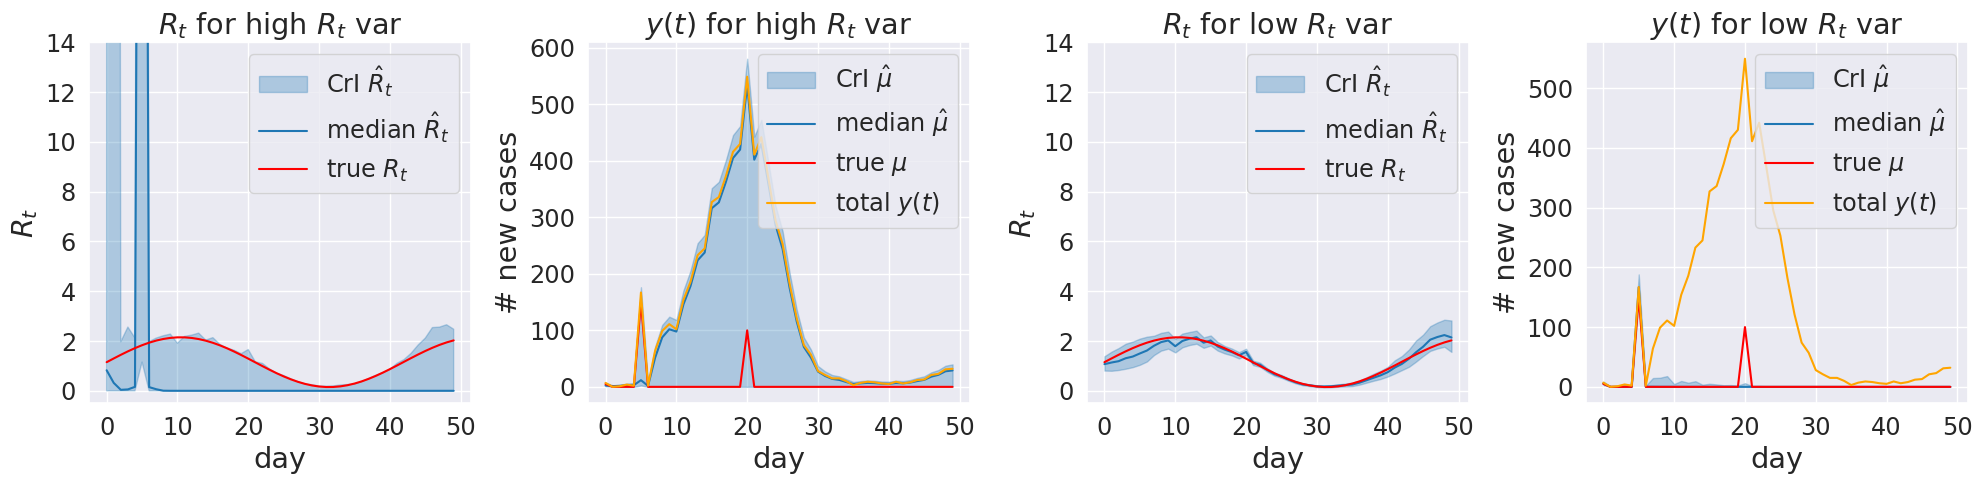

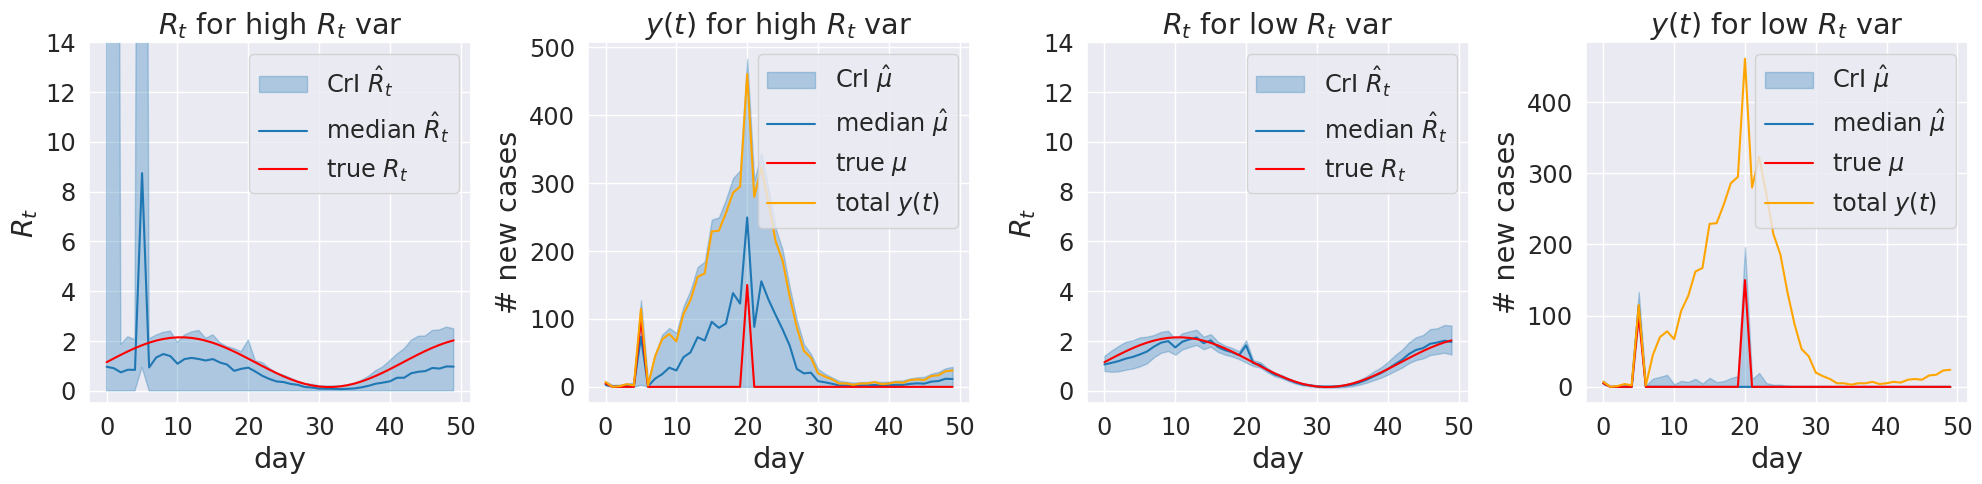

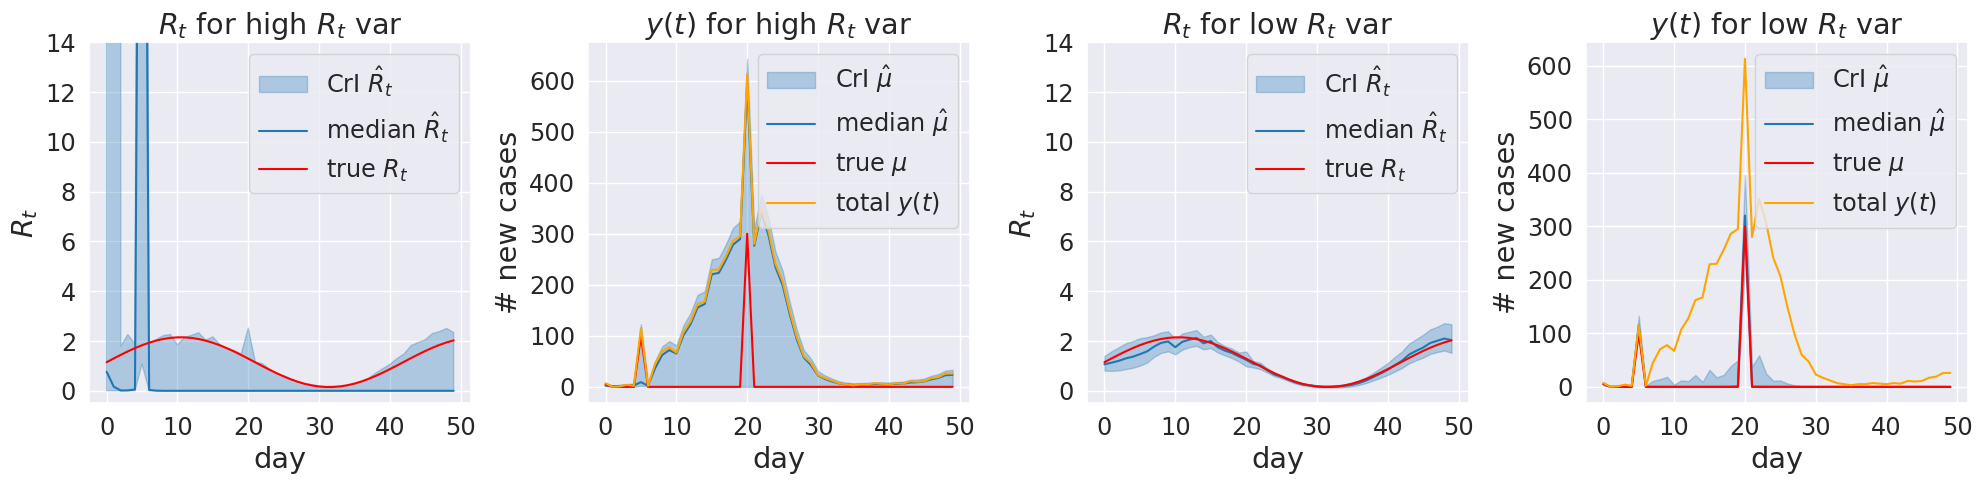

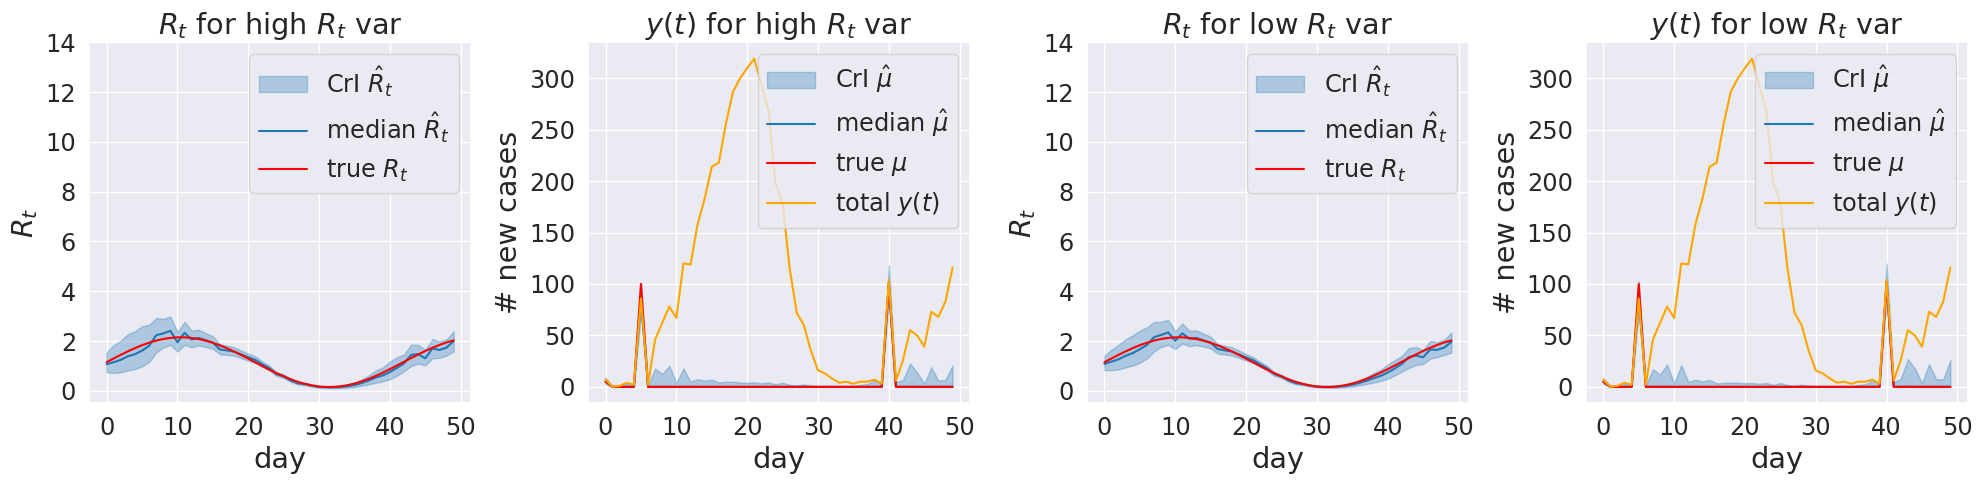

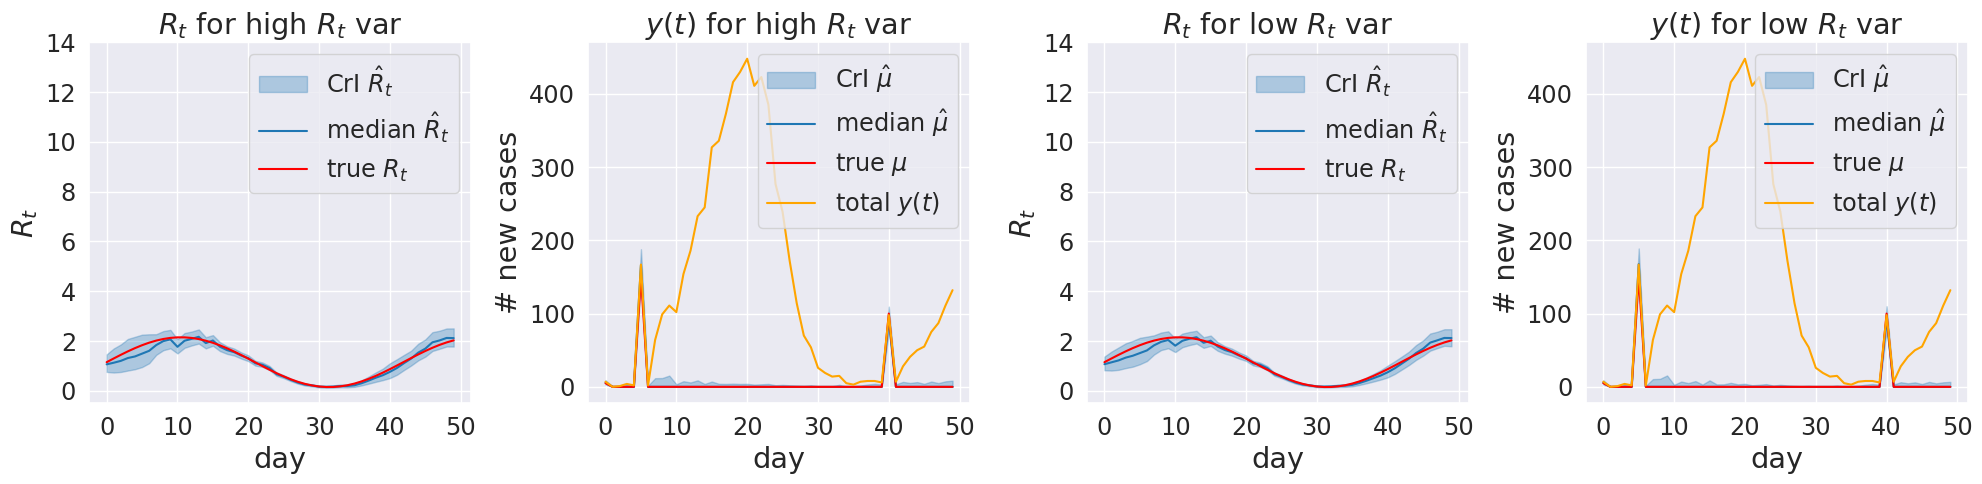

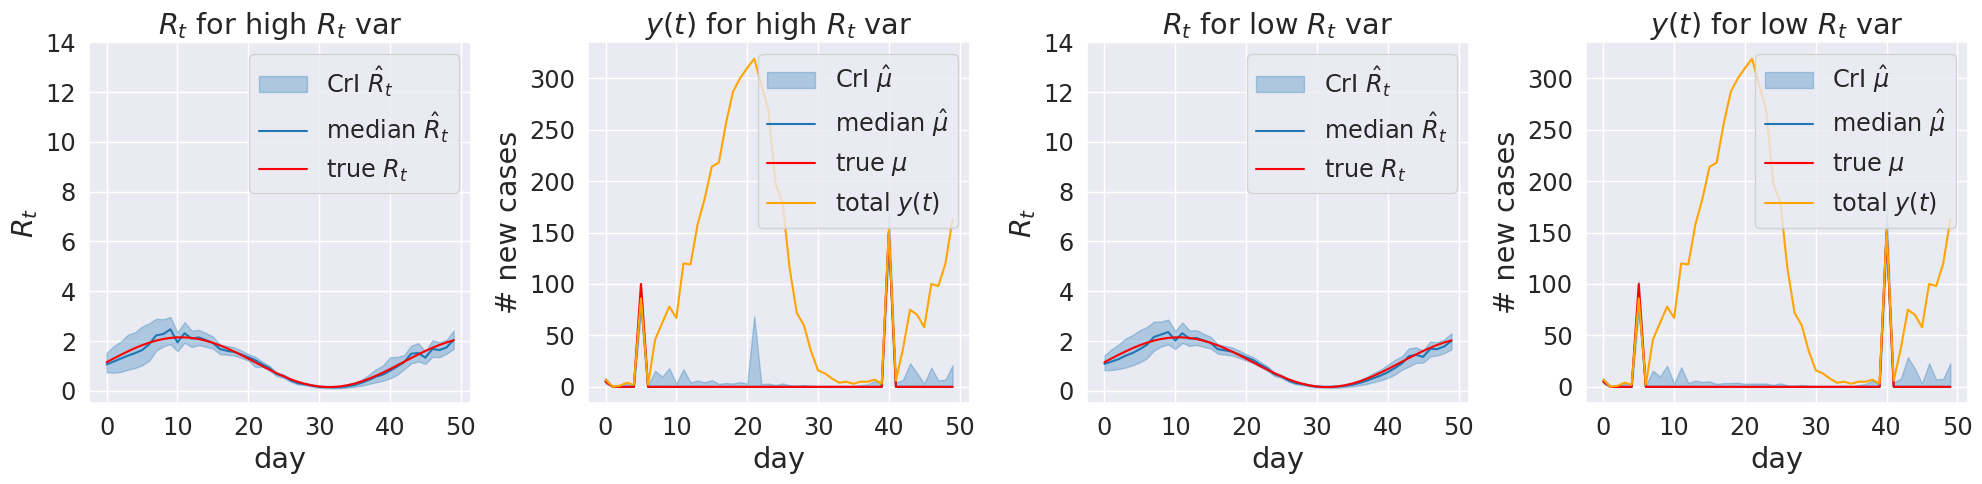

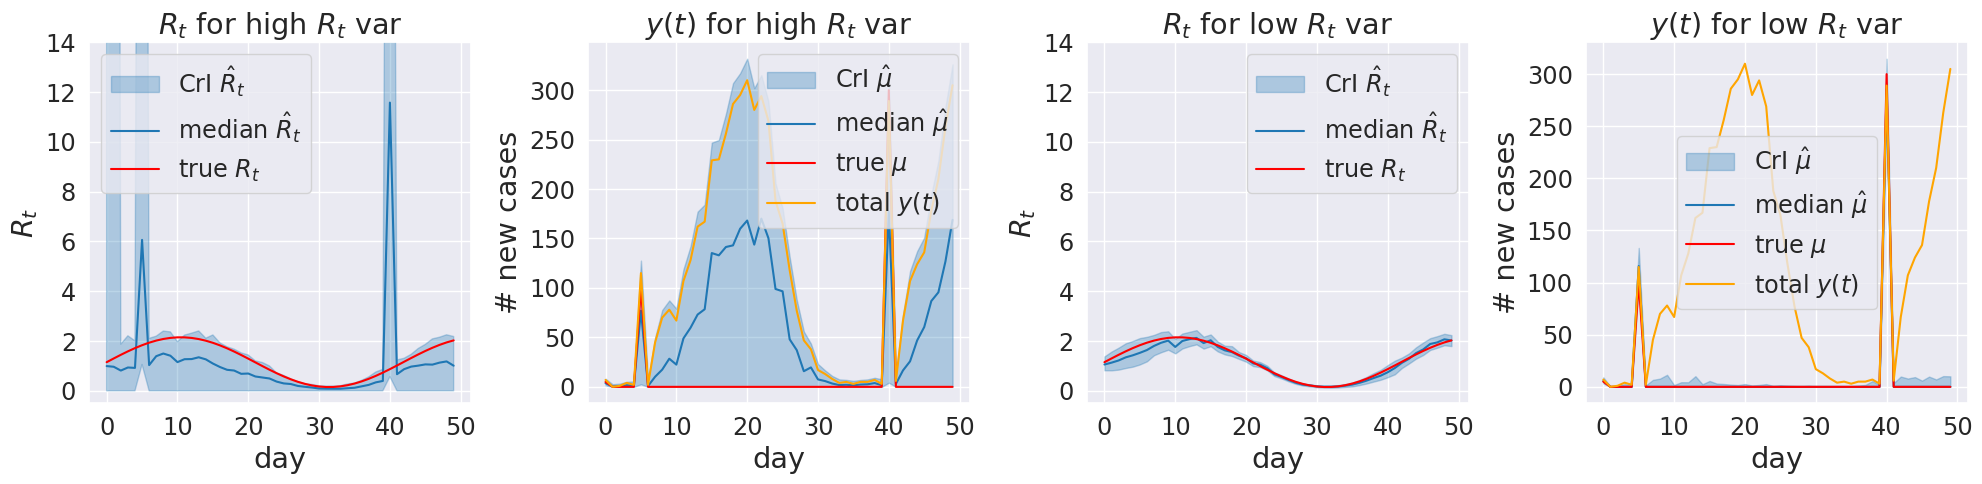

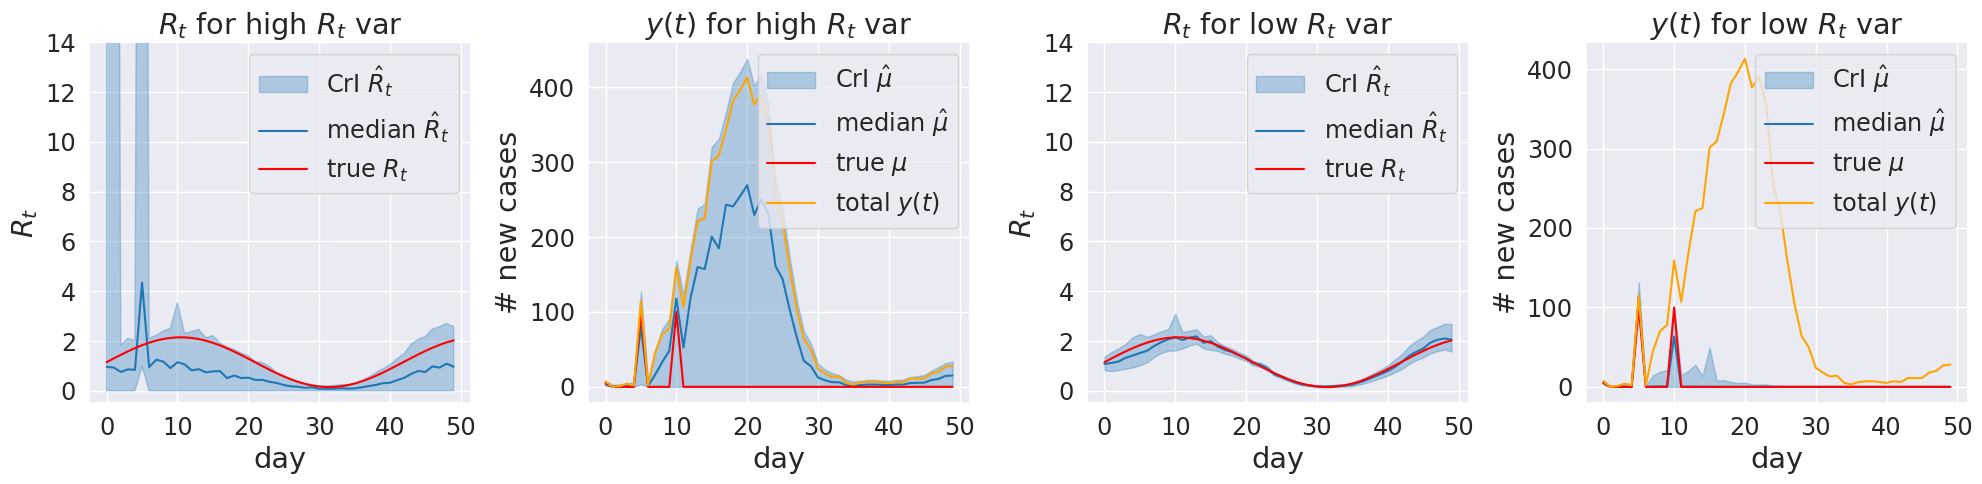

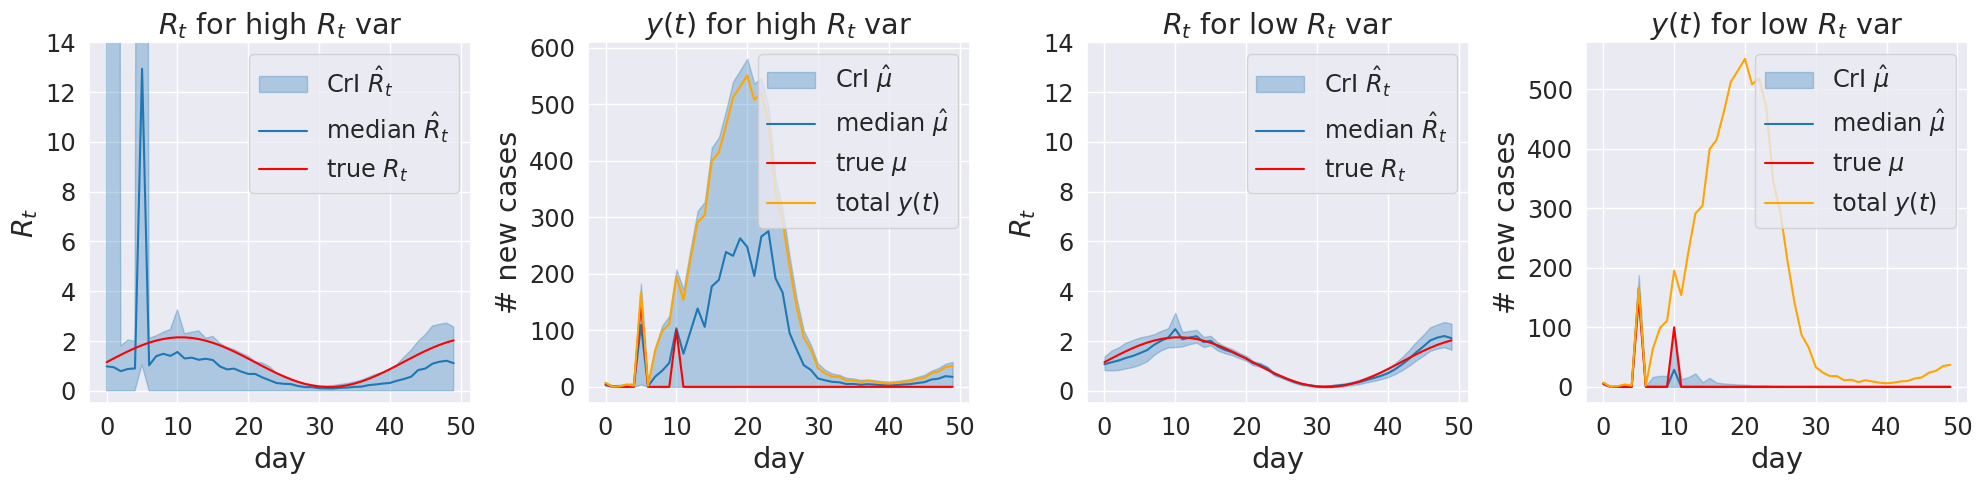

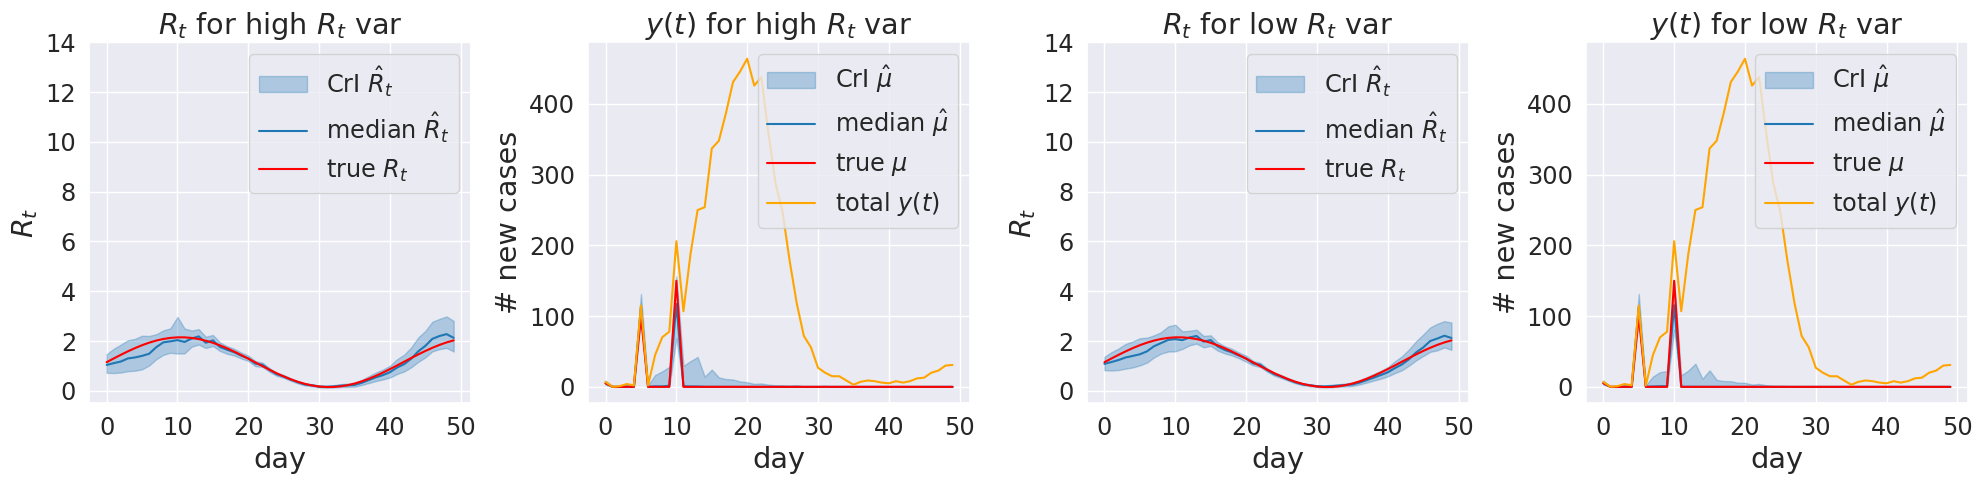

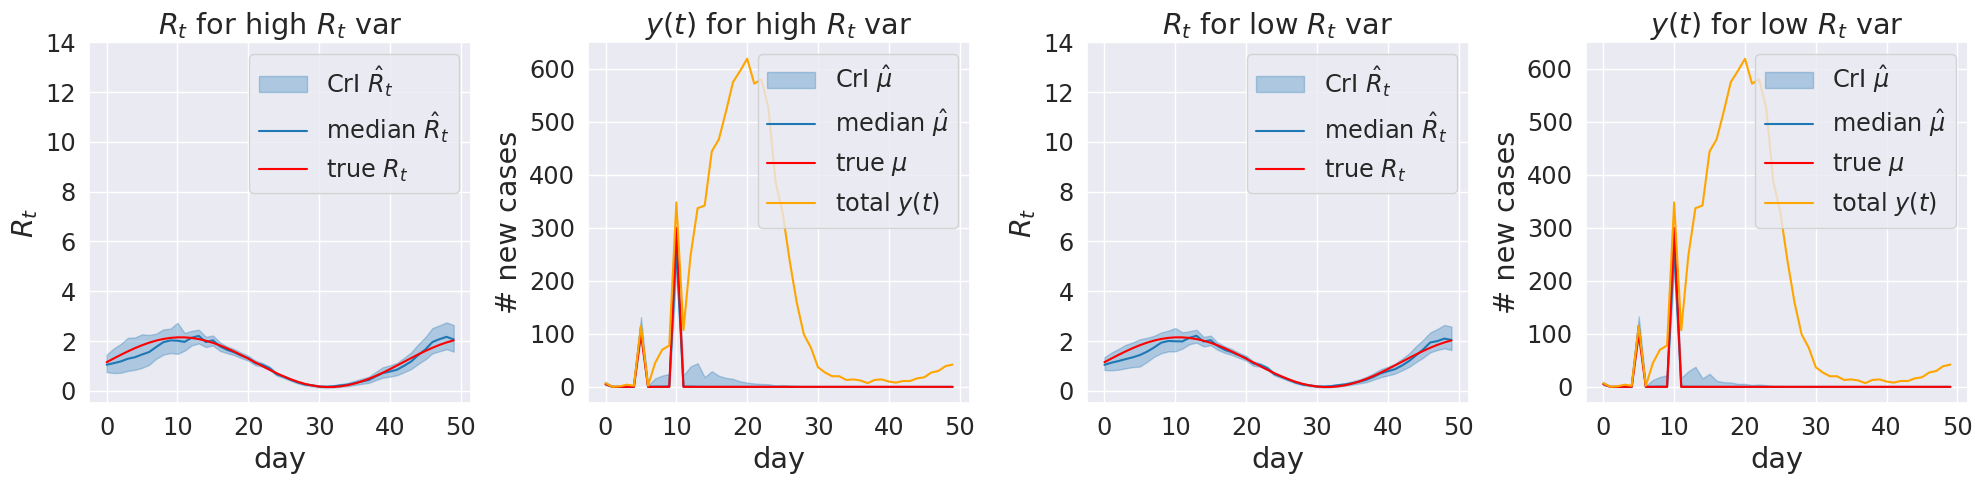

In [33]:
plot_posterior_two_samples(mcmc1, mcmc1a, Rt_df['R1'], mu_df['mu1'], y_df['y1'], title=scenarios_names[1])
plot_posterior_two_samples(mcmc2, mcmc2a, Rt_df['R2'], mu_df['mu2'], y_df['y2'], title=scenarios_names[2])
plot_posterior_two_samples(mcmc3, mcmc3a, Rt_df['R3'], mu_df['mu3'], y_df['y3'], title=scenarios_names[3])
plot_posterior_two_samples(mcmc4, mcmc4a, Rt_df['R4'], mu_df['mu4'], y_df['y4'], title=scenarios_names[4])
plot_posterior_two_samples(mcmc5, mcmc5a, Rt_df['R5'], mu_df['mu5'], y_df['y5'], title=scenarios_names[5])
plot_posterior_two_samples(mcmc6, mcmc6a, Rt_df['R6'], mu_df['mu6'], y_df['y6'], title=scenarios_names[6])
plot_posterior_two_samples(mcmc7, mcmc7a, Rt_df['R7'], mu_df['mu7'], y_df['y7'], title=scenarios_names[7])
plot_posterior_two_samples(mcmc8, mcmc8a, Rt_df['R8'], mu_df['mu8'], y_df['y8'], title=scenarios_names[8])
plot_posterior_two_samples(mcmc9, mcmc9a, Rt_df['R9'], mu_df['mu9'], y_df['y9'], title=scenarios_names[9])
plot_posterior_two_samples(mcmc10, mcmc10a, Rt_df['R10'], mu_df['mu10'], y_df['y10'], title=scenarios_names[10])
plot_posterior_two_samples(mcmc11, mcmc11a, Rt_df['R11'], mu_df['mu11'], y_df['y11'], title=scenarios_names[11])
plot_posterior_two_samples(mcmc12, mcmc12a, Rt_df['R12'], mu_df['mu12'], y_df['y12'], title=scenarios_names[12])


# Plot true Rt vs predicted Rt

In [ ]:
mcmc1.get_samples().keys()

dict_keys(['R', 'R_d', 'bin_mu', 'incidence', 'mu', 'mu_d', 'sigma_R', 'sigma_mu', 'temp', 'theta'])

In [ ]:
mcmc1.get_samples()['R'].mean(axis=0)

Array([1.0762924 , 1.1483029 , 1.2119309 , 1.3291101 , 1.3689601 ,
       1.4729711 , 1.5599124 , 1.794621  , 1.9769411 , 2.0330985 ,
       1.6932156 , 1.9770246 , 2.0722346 , 2.1728063 , 1.9043218 ,
       2.0468578 , 1.7646828 , 1.6305871 , 1.5528469 , 1.4259309 ,
       1.7046165 , 1.1107285 , 1.052481  , 0.82595426, 0.65764475,
       0.57832706, 0.45210522, 0.3360354 , 0.2516026 , 0.22325651,
       0.16960286, 0.15875658, 0.16046073, 0.15911502, 0.19172792,
       0.24100083, 0.3371492 , 0.46574658, 0.63336456, 0.7523038 ,
       0.9239799 , 1.1288984 , 1.2581799 , 1.5450981 , 1.6816465 ,
       1.7161148 , 1.9418402 , 2.0254297 , 2.1355388 , 2.0117717 ],      dtype=float32)

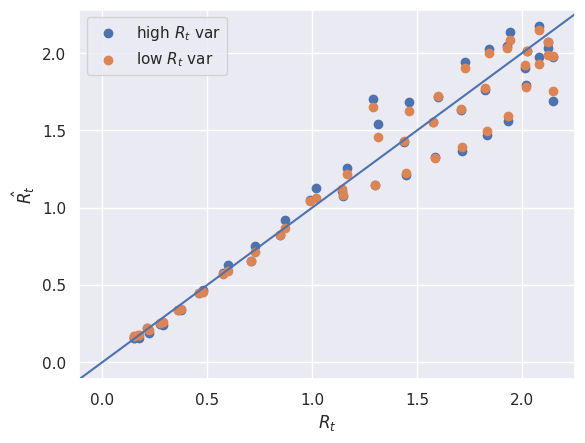

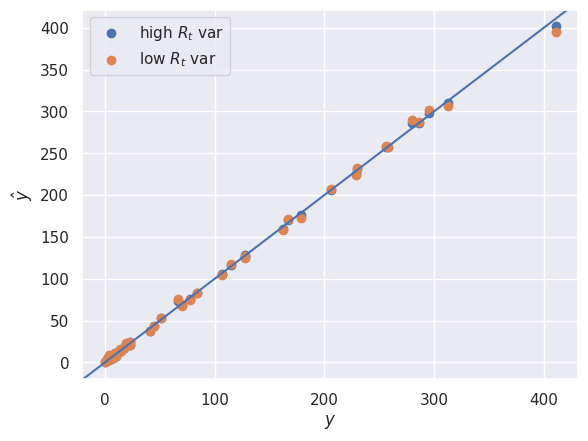

In [ ]:
def plot_Rt_true_vs_pred(mcmc_high, mcmc_low, log_scale=False):
  true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
  pred_high = mcmc_high.get_samples()['R']
  pred_low = mcmc_low.get_samples()['R']
  plt.scatter(true, pred_high.mean(axis=0), label = r'high $R_t$ var')
  plt.scatter(true, pred_low.mean(axis=0), label = r'low $R_t$ var')
  plt.xlabel(r'$R_t$')
  plt.ylabel(r'$\hat{R_t}$')
  plt.axline((0, 0), slope=1)
  if log_scale:
    plt.yscale('log')
    plt.xscale('log')
  plt.legend()
  plt.show()

plot_Rt_true_vs_pred(mcmc1, mcmc1a)


def plot_y_true_vs_pred(y_label, mcmc_high, mcmc_low, log_scale=False):
  true = y_df[y_label]
  pred_high = mcmc_high.get_samples()['incidence']
  pred_low = mcmc_low.get_samples()['incidence']
  plt.scatter(true, pred_high.mean(axis=0), label = r'high $R_t$ var')
  plt.scatter(true, pred_low.mean(axis=0), label = r'low $R_t$ var')
  plt.xlabel(r'$y$')
  plt.ylabel(r'$\hat{y}$')
  plt.axline((0, 0), slope=1)
  if log_scale:
    plt.yscale('log')
    plt.xscale('log')
  plt.legend()
  plt.show()

plot_y_true_vs_pred('y1', mcmc1, mcmc1a)


# (R)MSE


In [37]:
def plot_mse_Rt(mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
  pred_high = mcmc_high.get_samples()['R']
  pred_low = mcmc_low.get_samples()['R']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend(fontsize='x-large')
  plt.xlabel('day', fontsize='xx-large')
  ylabel = 'MSE for $R_t$'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel, fontsize='xx-large')
  plt.xticks(fontsize='x-large')
  plt.yticks(fontsize='x-large')
  # plt.show()

def plot_mse_y(true, mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  pred_high = mcmc_high.get_samples()['incidence']
  pred_low = mcmc_low.get_samples()['incidence']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend(fontsize='x-large')
  plt.xlabel('day', fontsize='xx-large')
  ylabel = r'MSE for $y(t)$'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel, fontsize='xx-large')
  plt.xticks(fontsize='x-large')
  plt.yticks(fontsize='x-large')
  # plt.show()

def plot_mse_mu(true, mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  pred_high = mcmc_high.get_samples()['mu']
  pred_low = mcmc_low.get_samples()['mu']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend(fontsize='x-large')
  plt.xlabel('day', fontsize='xx-large')
  ylabel = r'MSE for $\mu$'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel, fontsize='xx-large')
  plt.xticks(fontsize='x-large')
  plt.yticks(fontsize='x-large')
  # plt.show()


def plot_mse_Rt_and_y_and_mu(title, true_y, true_mu, mcmc_high, mcmc_low, squared = True, log_scale=False):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plot_mse_Rt(mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  plt.subplot(1,3,2)
  plot_mse_y(true_y, mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  plt.subplot(1,3,3)
  plot_mse_mu(true_mu, mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  # plt.suptitle(title)
  plt.tight_layout()

  if SAVE:
    namefile = 'MSE_' + title.replace(' ', '_')
    plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

  else:
    plt.show()


## Plot (R)MSE for R_t, incidence and importations

In [ ]:
# true_inc = y_df['y1']
# true_mu = mu_df['mu1']
# plot_mse_Rt_and_y_and_mu(scenarios_names[1], true_inc, true_mu, mcmc1, mcmc10, squared = False, log_scale=False)
# true_inc = y_df['y2']
# true_mu = mu_df['mu2']
# plot_mse_Rt_and_y_and_mu(scenarios_names[2], true_inc, true_mu, mcmc2, mcmc20, squared = False, log_scale=False)
# true_inc = y_df['y3']
# true_mu = mu_df['mu4']
# plot_mse_Rt_and_y_and_mu(scenarios_names[3], true_inc, true_mu, mcmc3, mcmc30, squared = False, log_scale=False)


In [35]:
scenarios_names

['placeholder',
 'second spike when $R_t$ decreasing, equal spikes',
 'second spike when $R_t$ decreasing, first spike higher',
 'second spike when $R_t$ decreasing, second spike higher, $\\mu_2 = 150$',
 'second spike when $R_t$ decreasing, second spike higher, $\\mu_2 = 300$',
 'second spike when $R_t$ increasing but inc ~ 0, equal spikes',
 'second spike when $R_t$ increasing but inc ~ 0, first spike higher',
 'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\\mu_2 = 150$',
 'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\\mu_2 = 300$',
 'second spike when $R_t$ increasing, equal spikes',
 'second spike when $R_t$ increasing, first spike higher',
 'second spike when $R_t$ increasing, second spike higher, $\\mu_2 = 150$',
 'second spike when $R_t$ increasing, second spike higher, $\\mu_2 = 300$']

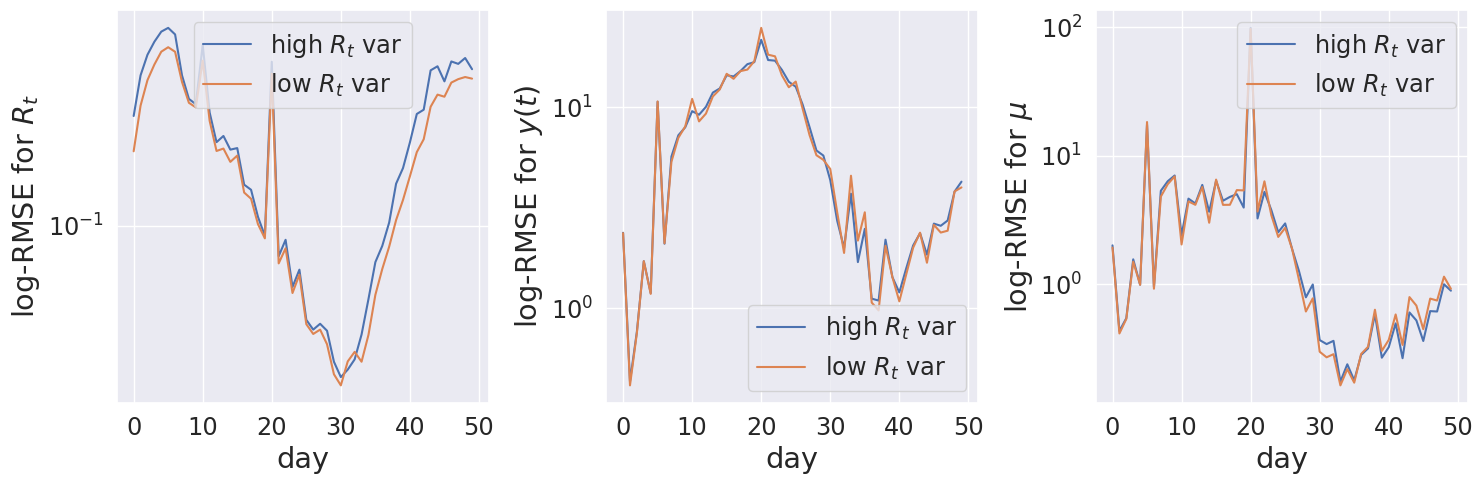

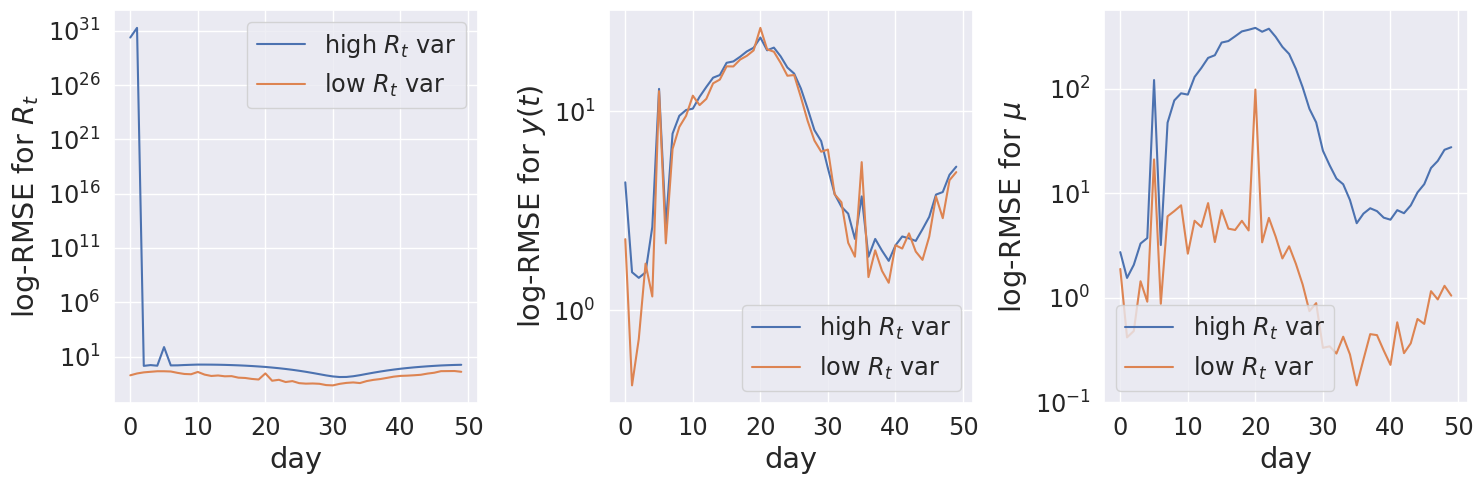

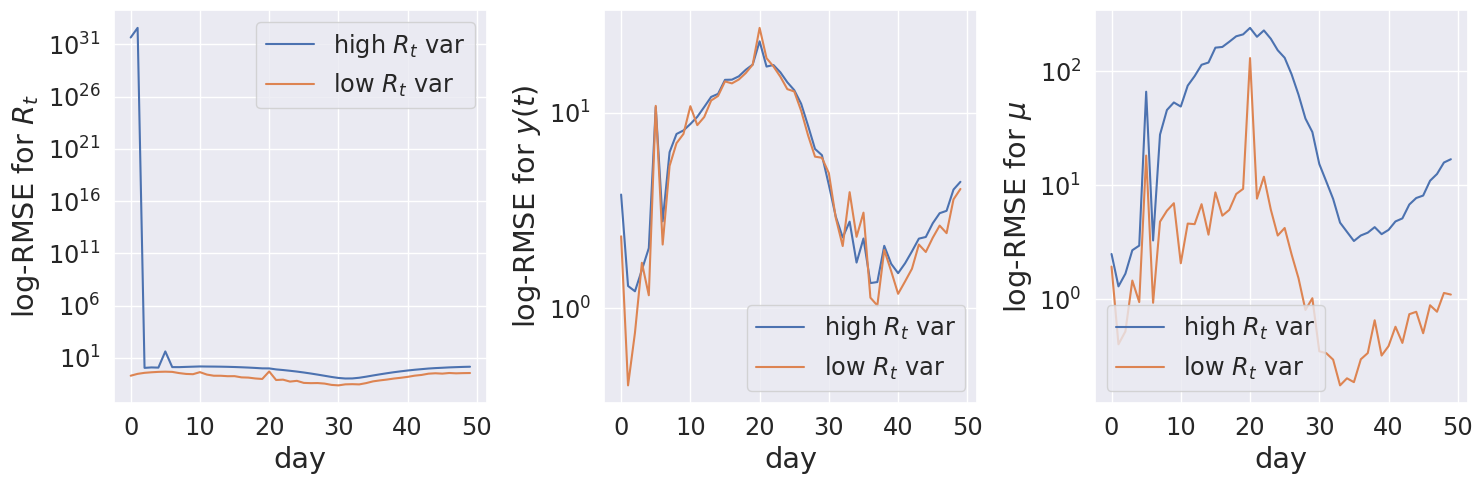

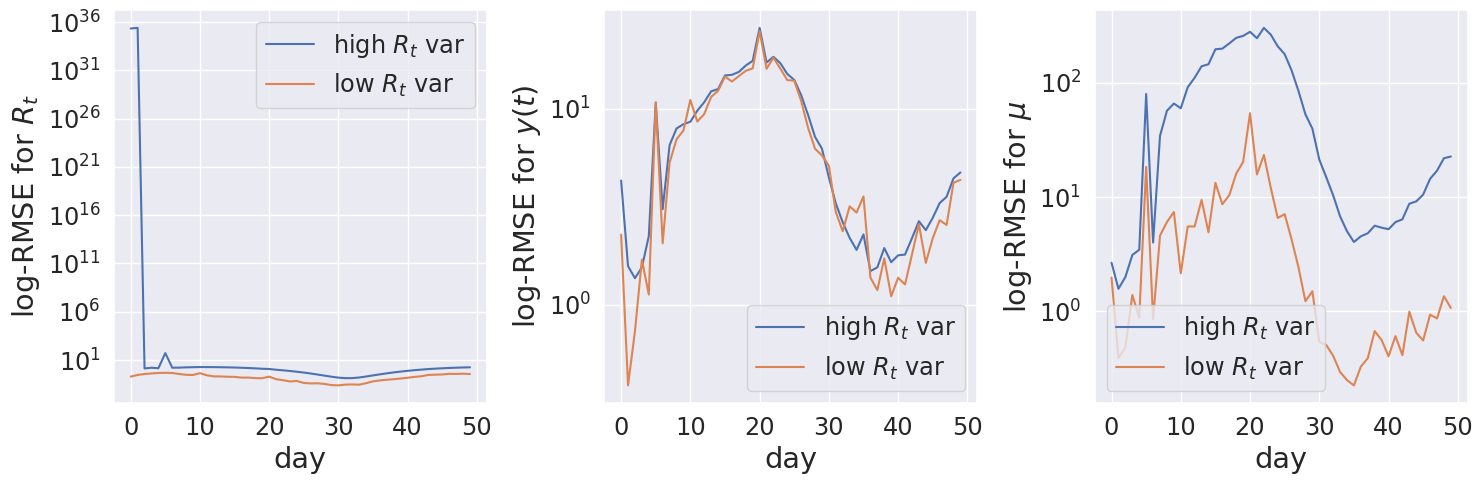

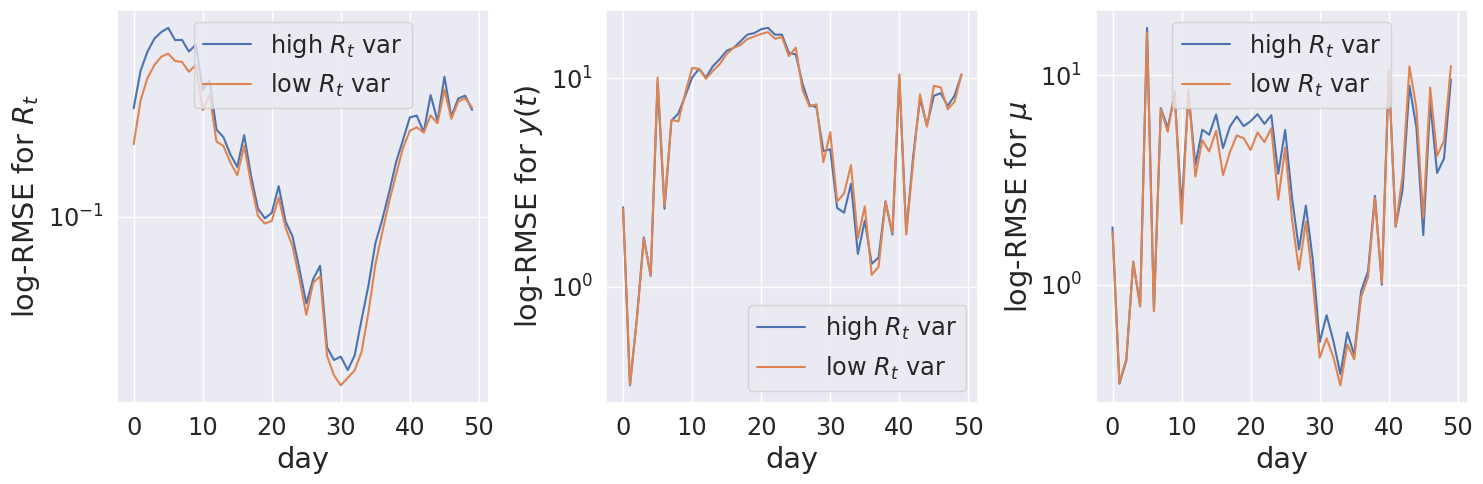

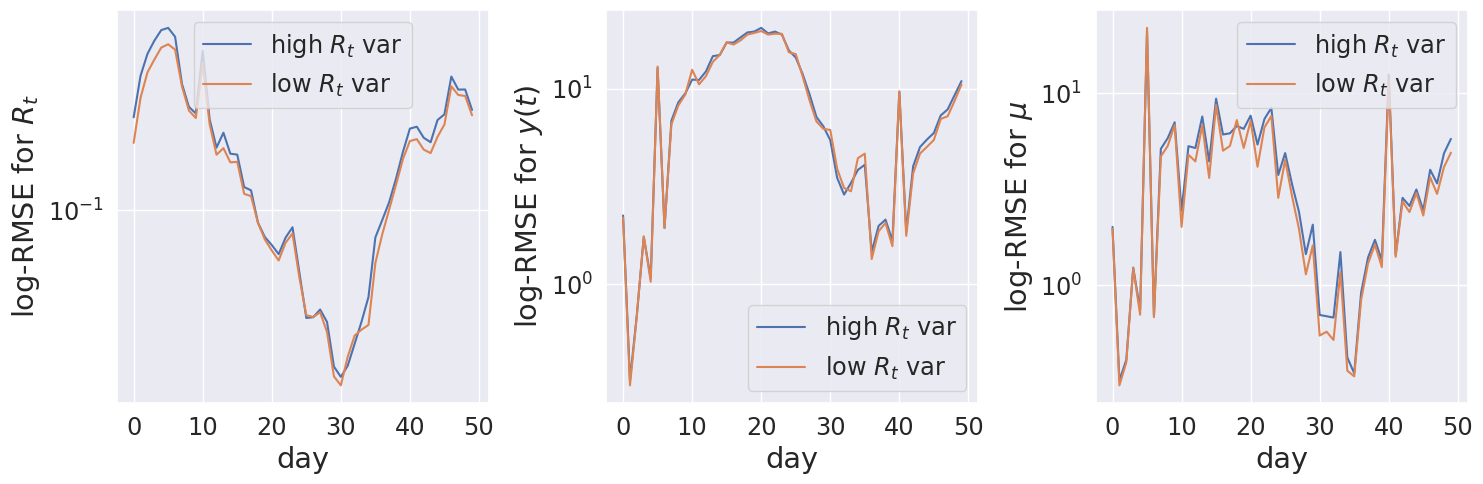

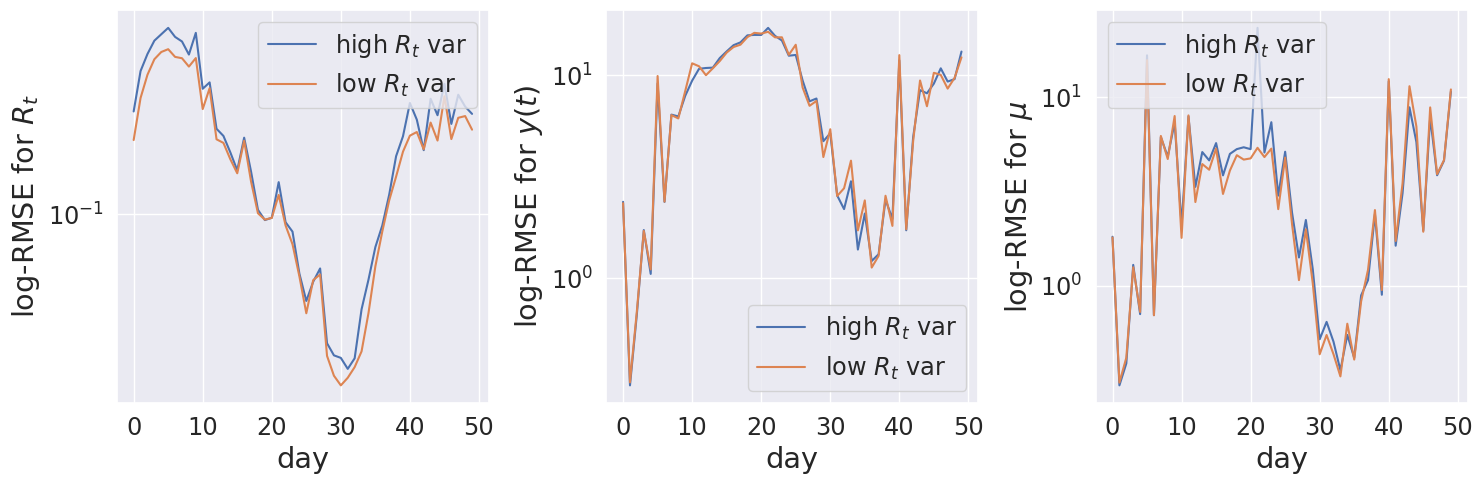

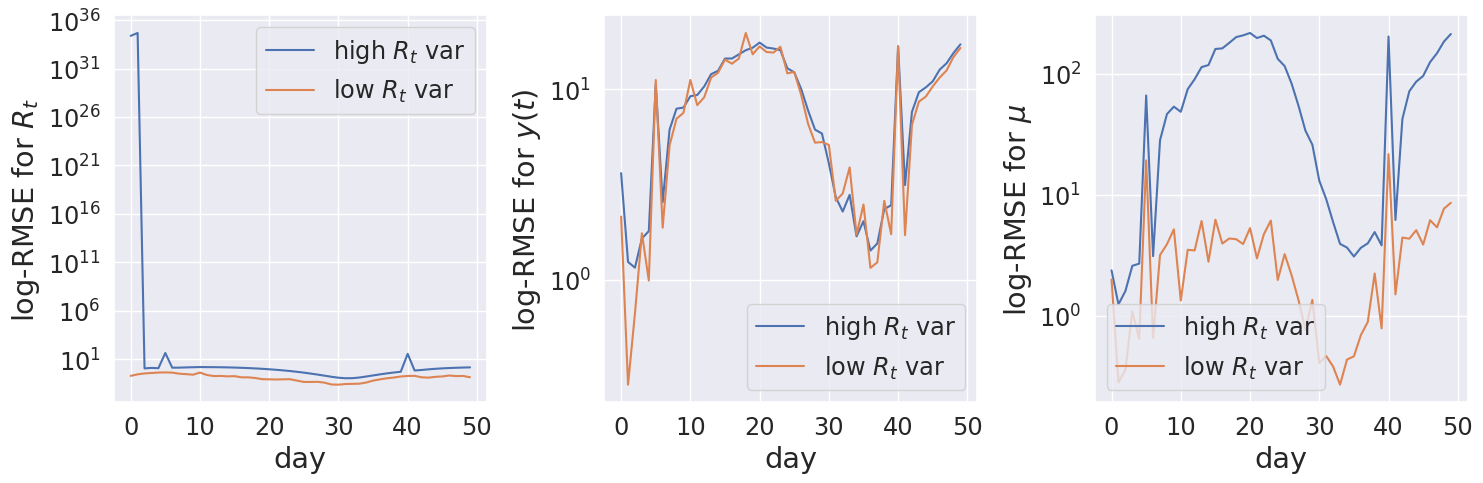

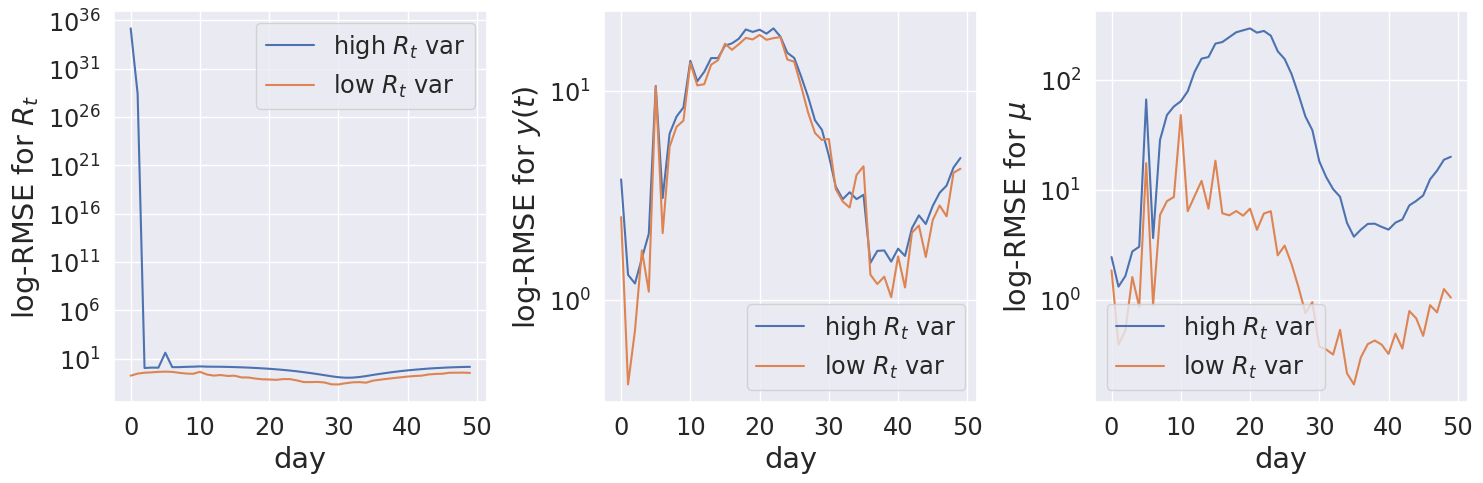

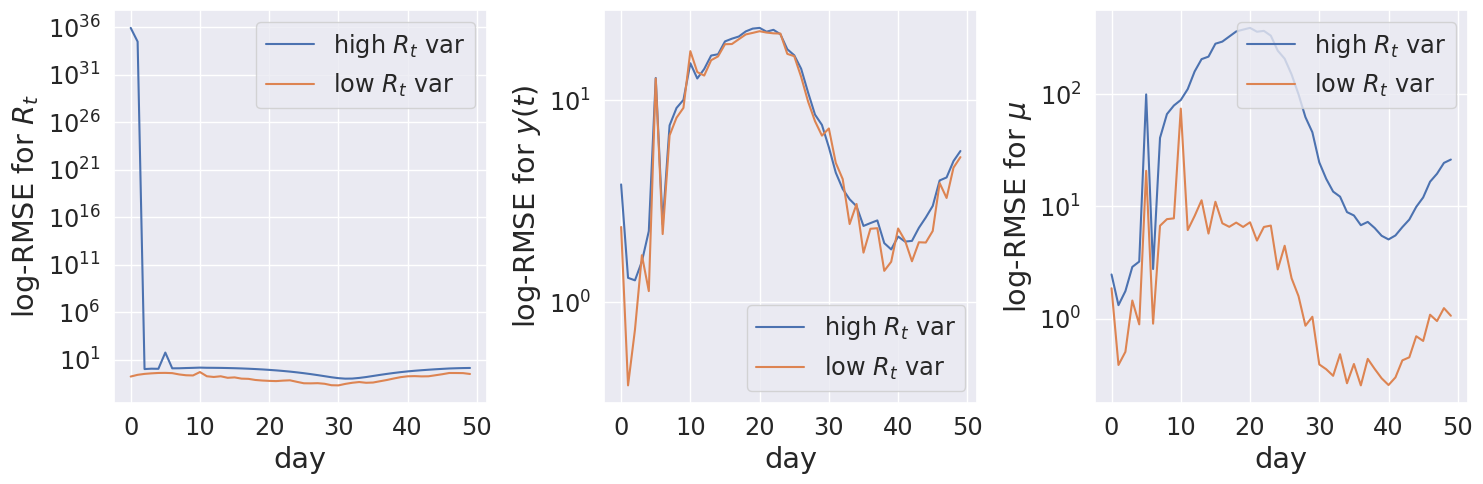

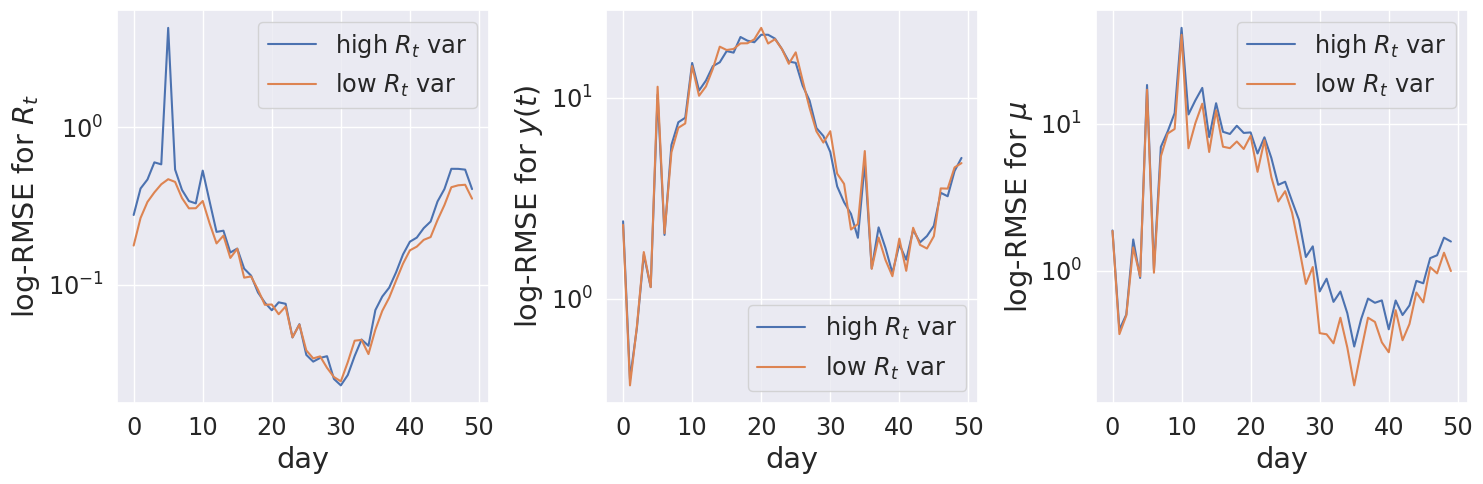

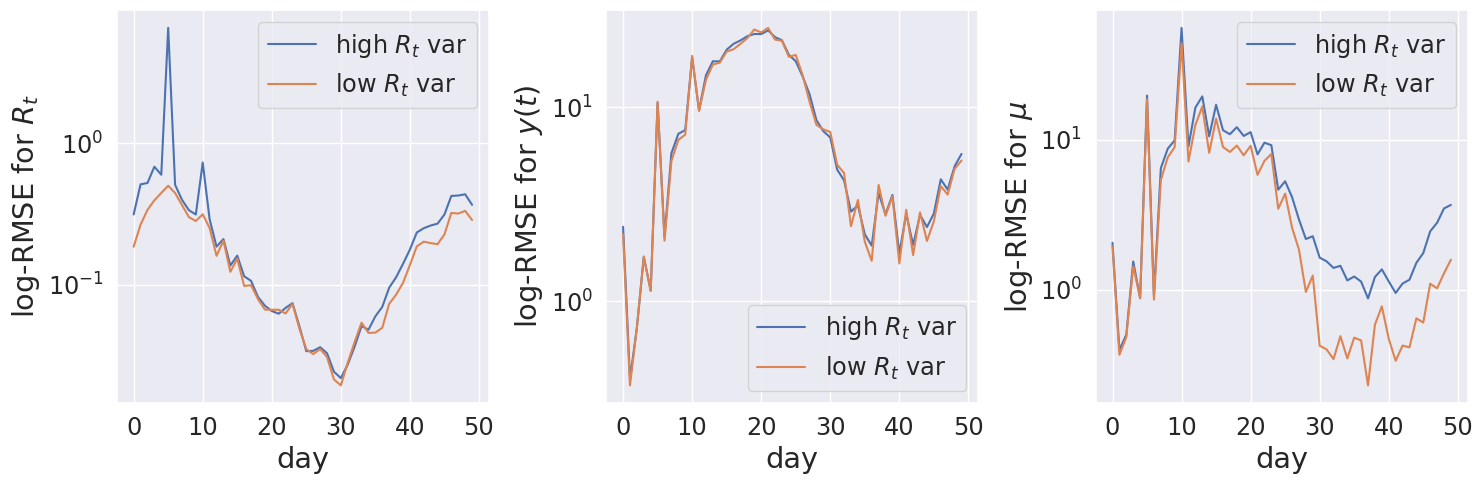

In [38]:
squared = False # calculate RMSE
log_scale = True  # on a log-scale

plot_mse_Rt_and_y_and_mu(scenarios_names[1], y_df['y1'], mu_df['mu1'], mcmc1, mcmc1a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[2], y_df['y2'], mu_df['mu2'], mcmc2, mcmc2a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[3], y_df['y3'], mu_df['mu3'], mcmc3, mcmc3a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[4], y_df['y4'], mu_df['mu4'], mcmc4, mcmc4a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[5], y_df['y5'], mu_df['mu5'], mcmc5, mcmc5a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[6], y_df['y6'], mu_df['mu6'], mcmc6, mcmc6a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[7], y_df['y7'], mu_df['mu7'], mcmc7, mcmc7a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[8], y_df['y8'], mu_df['mu8'], mcmc8, mcmc8a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[9], y_df['y9'], mu_df['mu9'], mcmc9, mcmc9a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[10], y_df['y10'], mu_df['mu10'], mcmc10, mcmc10a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[11], y_df['y11'], mu_df['mu11'], mcmc11, mcmc11a, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[12], y_df['y12'], mu_df['mu12'], mcmc12, mcmc12a, squared = squared, log_scale=log_scale)


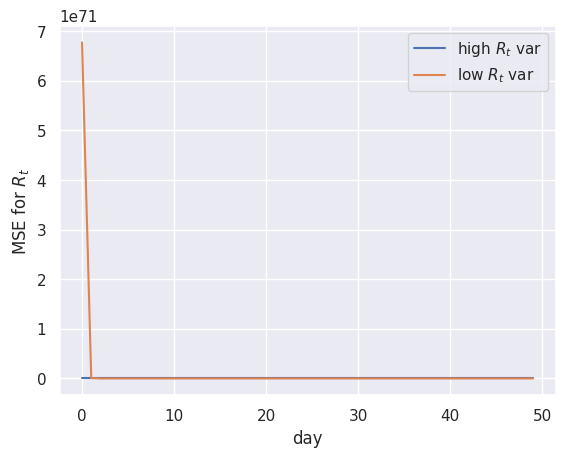

In [ ]:
plot_mse_Rt(mcmc1, mcmc10, squared = True, log_scale=False)
# plot_mse_Rt(mcmc1, mcmc10, squared = False, log_scale=False)
# plot_mse_Rt(mcmc1, mcmc10, squared = True, log_scale=True)
# plot_mse_Rt(mcmc1, mcmc10, squared = False, log_scale=True)

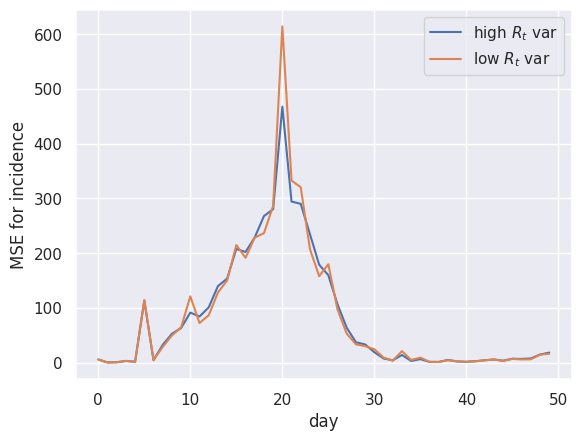

In [ ]:
true_inc = y_df['y1']
plot_mse_y(true_inc, mcmc1, mcmc1a, squared = True, log_scale=False)
# plot_mse_y(true_inc, mcmc1, mcmc10, squared = False, log_scale=False)
# plot_mse_y(true_inc, mcmc1, mcmc10, squared = True, log_scale=True)
# plot_mse_y(true_inc, mcmc1, mcmc10, squared = False, log_scale=True)

# MCMC diagnostics

I can only obtain a print statement, the specific values have to be fished out of that

In [ ]:
for count, value in enumerate(scenarios_names):
  print(count, value)

0 placeholder
1 second spike when $R_t$ decreasing, equal spikes
2 second spike when $R_t$ decreasing, first spike higher
3 second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 150$
4 second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 300$
5 second spike when $R_t$ increasing but inc ~ 0, equal spikes
6 second spike when $R_t$ increasing but inc ~ 0, first spike higher
7 second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 150$
8 second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 300$
9 second spike when $R_t$ increasing, equal spikes
10 second spike when $R_t$ increasing, first spike higher
11 second spike when $R_t$ increasing, second spike higher, $\mu_2 = 150$
12 second spike when $R_t$ increasing, second spike higher, $\mu_2 = 300$


In [ ]:
Rhat_range_high_var = ['-',
                       '1.00 - 1.05', '1.03 - 6.41', '1.03 - 6.50', '1.00 - 2.82',
                       '1.00 -1.02', '1.00 - 1.00', '1.01 - 1.22', '1.03 - 10.08',
                       '1.03 - 6.69', '1.01- 7.52', '1.00 - 1.17', '1.00 - 1.04',
]

Rhat_range_low_var = ['-',
                      '1.00 - 1.05', '1.00 - 1.07', '1.00 - 1.03', '1.00 - 1.03',
                      '1.00 - 1.02', '1.00 - 1.04', '1.00 - 1.04', '1.00 - 1.08',
                      '1.00 - 1.30', '1.00 - 1.04', '1.00 - 1.27', '1.00 - 1.14',
]

## obtained by running the below one by one

In [ ]:
# # just have to manually get that...
%%capture captured
mcmc12a.print_summary()

In [ ]:
#dir(captured)
#captured.outputs()
s = captured.stdout
s

'\n                mean       std    median      5.0%     95.0%     n_eff     r_hat\n    R_d[0]      0.05      0.15      0.04     -0.18      0.30    105.27      1.04\n    R_d[1]      0.12      0.19      0.12     -0.19      0.43   1996.44      1.00\n    R_d[2]      0.18      0.21      0.18     -0.17      0.52   3379.50      1.00\n    R_d[3]      0.25      0.22      0.24     -0.09      0.63   1782.66      1.01\n    R_d[4]      0.31      0.21      0.30     -0.04      0.67   3094.97      1.00\n    R_d[5]      0.35      0.23      0.36     -0.02      0.73     54.97      1.08\n    R_d[6]      0.45      0.18      0.45      0.15      0.76   3304.65      1.00\n    R_d[7]      0.56      0.15      0.55      0.34      0.81    978.53      1.01\n    R_d[8]      0.64      0.14      0.66      0.42      0.86   2264.61      1.00\n    R_d[9]      0.68      0.13      0.69      0.49      0.91   2611.06      1.00\n   R_d[10]      0.69      0.14      0.69      0.47      0.93   2359.84      1.00\n   R_d[11]   

In [ ]:
order_in_thesis = [0,
                   5, 6, 7, 8,
                   9, 10, 11, 12,
                   1, 2, 3, 4]

In [ ]:
scenarios_ordered = [scenarios_names[i] for i in order_in_thesis]
scenarios_ordered = [el.replace('second spike when $R_t$ ', '..') for el in scenarios_ordered]

In [ ]:
Rhat_vals_df = pd.DataFrame(index = scenarios_ordered, columns = ['high $R_t$ var', 'low $R_t$ var'])
Rhat_vals_df['high $R_t$ var'] = [Rhat_range_high_var[i] for i in order_in_thesis]
Rhat_vals_df['low $R_t$ var'] = [Rhat_range_low_var[i] for i in order_in_thesis]
Rhat_vals_df.drop(['placeholder'], inplace = True) # drop placeholder row
Rhat_vals_df

,high $R_t$ var,low $R_t$ var
"..increasing but inc ~ 0, equal spikes",1.00 -1.02,1.00 - 1.02
"..increasing but inc ~ 0, first spike higher",1.00 - 1.00,1.00 - 1.04
"..increasing but inc ~ 0, second spike higher, $\mu_2 = 150$",1.01 - 1.22,1.00 - 1.04
"..increasing but inc ~ 0, second spike higher, $\mu_2 = 300$",1.03 - 10.08,1.00 - 1.08
"..increasing, equal spikes",1.03 - 6.69,1.00 - 1.30
"..increasing, first spike higher",1.01- 7.52,1.00 - 1.04
"..increasing, second spike higher, $\mu_2 = 150$",1.00 - 1.17,1.00 - 1.27
"..increasing, second spike higher, $\mu_2 = 300$",1.00 - 1.04,1.00 - 1.14
"..decreasing, equal spikes",1.00 - 1.05,1.00 - 1.05
"..decreasing, first spike higher",1.03 - 6.41,1.00 - 1.07


In [ ]:
str_latex = Rhat_vals_df.to_latex(index=True,
                  caption = 'Ranges of $\hat{R}$ diagnostics for the different models'' parameters in considered scenarios.'
)
str_latex = str_latex.replace('\$R\_t\$', '$R_t$')
str_latex = str_latex.replace('\\$\\textbackslash mu\\_2 = 150\$', '$\mu_2 = 150$')
str_latex = str_latex.replace('\\$\\textbackslash mu\\_2 = 300\$', '$\mu_2 = 300$')
str_latex = str_latex.replace('\\textasciitilde  0', '$\approx$ 0')
str_latex = str_latex.replace('{}', 'second spike when $R_t$ ..')


print(str_latex)


\begin{table}
\centering
\caption{Ranges of $\hat{R}$ diagnostics for the different models parameters in considered scenarios.}
\begin{tabular}{lll}
\toprule
second spike when $R_t$ .. & high $R_t$ var & low $R_t$ var \\
\midrule
..increasing but inc $pprox$ 0, equal spikes             &     1.00 -1.02 &   1.00 - 1.02 \\
..increasing but inc $pprox$ 0, first spike higher       &    1.00 - 1.00 &   1.00 - 1.04 \\
..increasing but inc $pprox$ 0, second spike higher, ... &    1.01 - 1.22 &   1.00 - 1.04 \\
..increasing but inc $pprox$ 0, second spike higher, ... &   1.03 - 10.08 &   1.00 - 1.08 \\
..increasing, equal spikes                         &    1.03 - 6.69 &   1.00 - 1.30 \\
..increasing, first spike higher                   &     1.01- 7.52 &   1.00 - 1.04 \\
..increasing, second spike higher, $\mu_2 = 150$   &    1.00 - 1.17 &   1.00 - 1.27 \\
..increasing, second spike higher, $\mu_2 = 300$   &    1.00 - 1.04 &   1.00 - 1.14 \\
..decreasing, equal spikes                    

<ipython-input-31-c0bd5e969665>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  str_latex = Rhat_vals_df.to_latex(index=True,


# CRPS

In [ ]:
true = np.array(Rt_df['R1'])
pred = mcmc1.get_samples()['R']
n = pred.shape[0]
true = np.tile(true, n).reshape(pred.shape)

# mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)

In [ ]:
print(pred.shape)
print(crps(true, pred).shape)
print(crps(true, pred).mean(axis=0).shape)

(80000, 50)
(80000, 50)
(50,)


In [ ]:
# def get_crps_Rt(mcmc_high, mcmc_low, log_scale=False):
#   true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
#   pred_high = mcmc_high.get_samples()['R']
#   pred_low = mcmc_low.get_samples()['R']

#   return crps(truth, pred_high)



# crps(truth, samples)